# Predicting ICU Length of Stay
## Final Dataset Preparation
### Feature Selection and Cleaning

First, we select the predictive features that will be used to train the neural network regression model for ICU Length of Stay (LOS). The target variable is LOS_LOG, a logarithmically transformed version of LOS, which improves symmetry and stabilizes variance. We remove: Identifier columns (SUBJECT_ID, HADM_ID, ICUSTAY_ID); Outcome columns (LOS, LOS_LOG, HOSPITAL_EXPIRE_FLAG) which should not be included as predictors; Any rows with NaN values, since PyTorch tensors cannot contain missing data. The resulting matrix X contains only clean, numerical features suitable for normalization and model training. This ensures that the input data is well-structured, fully numeric, and compatible with downstream PyTorch operations.

In [59]:
# === Essential Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [60]:
# === Configuration Constants ===
EXPORT_PATH = "../data/processed/"
ASSETS_PATH = "../assets/plots/modeling/"
# === Load dataset ===
df_final = pd.read_csv(EXPORT_PATH + "df_model_ready_cleaned.csv")

# === Confirm structure ===
print(df_final.shape)
display(df_final.head())

(1900, 72)


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,AGE,GENDER,ADMISSION_TYPE,ADMISSION_LOCATION,INSURANCE,FIRST_CAREUNIT,LOS,...,Output_Emesis_24h,Output_Gastric_24h,Output_Other_24h,Output_Stool_24h,Output_Urine_24h,NUM_COMORBIDITIES_x,NUM_COMORBIDITIES_y,NUM_COMORBIDITIES,age_censored,COMORBIDITY_CLASS
0,269,106296,206613,40,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicaid,MICU,3.2788,...,0.0,0.0,0.0,0.0,3850.0,8,8,8,0,Low
1,275,129886,219649,82,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,CCU,7.1314,...,0.0,0.0,200.0,0.0,1370.0,15,15,15,0,Moderate
2,292,179726,222505,57,F,URGENT,TRANSFER FROM HOSP/EXTRAM,Private,MICU,0.8854,...,0.0,2230.0,3500.0,0.0,695.0,8,8,8,0,Low
3,305,194340,217232,76,F,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,Medicare,SICU,2.4370,...,0.0,0.0,1240.0,0.0,0.0,16,16,16,0,Moderate
4,323,143334,264375,57,M,EMERGENCY,EMERGENCY ROOM ADMIT,Medicare,MICU,3.0252,...,0.0,0.0,700.0,0.0,855.0,11,11,11,0,Moderate


In [61]:
cols_to_remove = ['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS', 'HOSPITAL_EXPIRE_FLAG']

y = df_final['LOS']
X = df_final.drop(columns=cols_to_remove, errors='ignore')

# X = X.dropna()  # Delete NaN
# One-Hot Encoding: conversione delle feature categoriali in binarie
X = pd.get_dummies(X)
X = X.fillna(X.median())  # oppure SimpleImputer
y = y.loc[X.index]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (1900, 1985)
Shape of y: (1900,)


### Train/Validation/Test Split
Now, dataset is split into three sets: training (70%), used to fit the model; validation (15%), used to monitor performance during training and avoid overfitting; and test (15%), used only once at the end to evaluate the final model. The target variable is `LOS_LOG`, the log-transformed ICU Length of Stay. To ensure consistency in the target distribution and reproducibility of results, a fixed `random_state` is used.
This split must be: *reproducible*, using a fixed random_state; *stratified*, if the target variable is categorical. Since we're working with a continuous regression target (LOS_LOG), stratification is not necessary. However, it's essential to ensure that all three sets are statistically representative of the full dataset.

In [62]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (1330, 1985), (1330,)
Validation set: (285, 1985), (285,)
Test set: (285, 1985), (285,)


## Traditional ML Models
### Baseline: Linear Regression
In this section, we introduce a linear regression model to serve as a performance baseline for predicting ICU length of stay (LOS). Linear regression is one of the most fundamental statistical learning methods, offering interpretability, low computational cost, and ease of implementation. It is particularly useful as a first step in assessing whether there exists a roughly linear relationship between the engineered features and the target variable (LOS).

From a theoretical standpoint, linear regression attempts to fit a hyperplane in the feature space that minimizes the mean squared error between the predicted and observed LOS values. Despite its simplicity, it can provide valuable insight: if its predictive performance is competitive, then more complex models may offer marginal improvement at the cost of interpretability and computational complexity.

In this implementation, we fit the model on the training data and immediately predict the outcomes on the test set. No regularization or feature selection is applied at this stage, as the primary aim is to establish a naive yet informative reference point. The residuals and performance metrics (evaluated later) will help us understand whether the linear model captures any meaningful variance in the data.

In [63]:
# === Model ===
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

#### Evaluation Metrics for Linear Regression
After training the linear regression model, we evaluate its predictive performance using three widely adopted regression metrics: Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and the coefficient of determination (R²). Each of these offers complementary insight into the model's ability to approximate the true LOS values in the test set.

MAE (3.76) indicates the average magnitude of prediction errors in the same unit as the target variable (days), without considering their direction. An MAE of nearly 4 suggests that, on average, predictions are off by approximately four ICU days.

RMSE (42.95), which penalizes larger errors more heavily due to squaring, appears disproportionately high in relation to MAE. This discrepancy hints at the presence of substantial outliers or extreme mispredictions, which is not uncommon in ICU LOS distributions that exhibit strong right-skewed behavior.

R² (0.12) measures the proportion of variance in LOS explained by the model. A value close to 0 signals that the linear model captures very little of the variability in the outcome, reinforcing the hypothesis that linear relationships alone are insufficient to model this problem effectively.

These results confirm the limitations of linear regression in this clinical context and justify the exploration of more flexible and non-linear modeling techniques, such as decision trees or ensemble methods.

In [64]:
# === Evaluation Metrics ===
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"[Linear Regression] MAE: {mae_lr:.2f}, RMSE: {rmse_lr:.2f}, R²: {r2_lr:.2f}")

[Linear Regression] MAE: 3.76, RMSE: 42.95, R²: 0.12


#### Scatter Plot Analysis for Linear Regression
The scatter plot below offers a visual assessment of the linear regression model’s predictive accuracy by comparing the true Length of Stay (LOS) values (x-axis) with the predicted ones (y-axis). Ideally, a perfect model would produce points aligned along the 45-degree red dashed line, indicating identical predicted and actual outcomes.

However, the displayed pattern reveals several limitations of the linear model:
- A strong concentration of predictions is clustered in the lower-left quadrant, suggesting that the model systematically underestimates higher LOS values.
- The dispersion of points increases as true LOS increases, indicating poor generalization in the higher range — a common issue in healthcare datasets where outlier cases (e.g., long ICU stays) are rare but clinically significant.
- The model lacks the flexibility to capture non-linear relationships or heteroscedastic variance in the data, likely contributing to the high RMSE observed previously.

This visualization reinforces the numerical findings and supports the hypothesis that linear regression is insufficient for accurately modeling LOS in critically ill patients, particularly in capturing extreme cases.

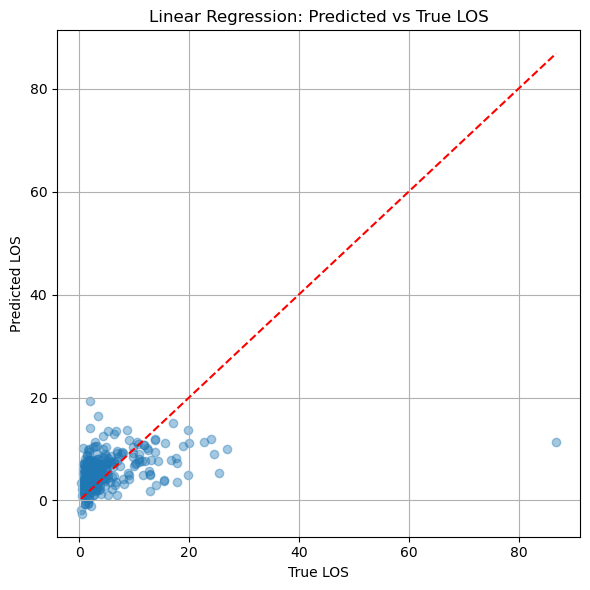

In [65]:
# === Scatter Plot: True vs Predicted ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True LOS")
plt.ylabel("Predicted LOS")
plt.title("Linear Regression: Predicted vs True LOS")
plt.grid(True)
plt.tight_layout()
plt.savefig(ASSETS_PATH + "linear_regression_scatter.png")
plt.show()

#### Distribution of Prediction Errors for Linear Regression
The histogram presented below illustrates the distribution of prediction errors, calculated as the difference between the true and predicted LOS values. This visualization is critical for diagnosing model behavior, particularly with respect to bias, variance, and the presence of outliers.

Several key observations emerge from this plot:

* **Centered Mode near Zero**: The bulk of prediction errors cluster tightly around 0, indicating that the model is reasonably well-calibrated for the majority of samples with shorter ICU stays.
* **Right-Skewed Tail**: A long right tail is clearly visible, with errors extending beyond +60. These represent severe underpredictions, where the true LOS is significantly longer than what the model estimated. This aligns with previous findings (e.g., RMSE >> MAE) and reflects the model's inability to anticipate prolonged stays.
* **Mild Left Tail**: The presence of some negative errors (overpredictions) shows that the model also overestimates LOS in a small number of cases, though to a lesser extent.
* **Heteroscedastic Behavior**: The widening error range for longer LOS values (as seen in the previous scatter plot) is consistent with this asymmetric error distribution and may require more flexible modeling strategies to address.

Overall, the error distribution confirms the limitations of linear regression in this context and provides motivation for exploring tree-based or ensemble models that can handle non-linearity and extreme values more robustly.

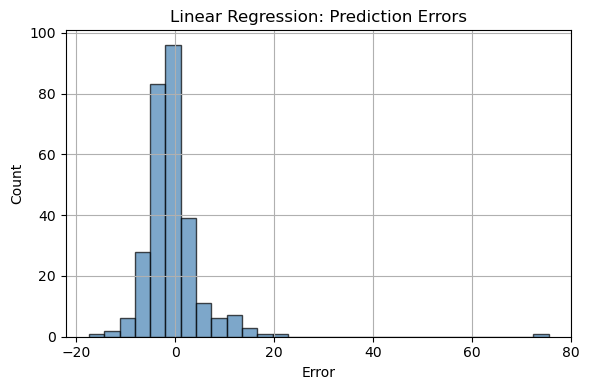

In [66]:
# === Histogram of Errors ===
errors_lr = y_test - y_pred_lr
plt.figure(figsize=(6, 4))
plt.hist(errors_lr, bins=30, alpha=0.7, color="steelblue", edgecolor="k")
plt.title("Linear Regression: Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(ASSETS_PATH + "linear_regression_errors_histogram.png")
plt.show()

### Decision Tree Regressor
In this section, we train a Decision Tree Regressor using default hyperparameters to assess whether a non-linear model can outperform the linear baseline in predicting ICU Length of Stay (LOS). Unlike linear regression, decision trees are non-parametric models capable of capturing complex, non-linear relationships and interactions between features without requiring explicit feature transformations.
By recursively partitioning the feature space based on impurity minimization (e.g., reduction in mean squared error for regression), decision trees are able to model localized behaviors in the data — an especially useful trait in clinical datasets where the target variable is affected by heterogeneous and often non-additive factors (e.g., comorbidities, interventions, organ support).
Here, we fit a decision tree with default depth and splitting criteria, serving both as a performance benchmark and as a diagnostic tool to explore model behavior before considering more robust ensemble approaches like Random Forests or Gradient Boosted Trees.

In [67]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

#### Evaluation Metrics for Decision Tree
The performance metrics reported here provide insight into the predictive behavior of the decision tree model when applied to the ICU Length of Stay (LOS) prediction task.

MAE = 4.20: This is slightly worse than the linear regression baseline (MAE ≈ 3.76), indicating that the average absolute deviation from the true LOS values has increased. While decision trees can capture non-linearities, they can also overfit if not regularized.

RMSE = 67.70: The root mean squared error has increased dramatically compared to the linear model (42.95), suggesting that the model makes some very large errors. This is often symptomatic of overfitting, where the model captures idiosyncratic patterns in the training data that do not generalize.

R² = -0.38: A negative R² implies that the model performs worse than a simple mean-based predictor. This further reinforces the conclusion that the default decision tree configuration is not effective in this context and likely suffers from overfitting to noise in the training set.

Taken together, these results suggest that a decision tree without hyperparameter tuning may be too flexible, especially given the high dimensionality of the feature space and the likely sparsity or skewness of certain variables. More sophisticated ensemble methods (e.g., Random Forest, XGBoost) or controlled regularization (e.g., max depth, min samples per leaf) are needed to stabilize performance.

In [68]:
# === Evaluation Metrics ===
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)
print(f"[Decision Tree] MAE: {mae_dt:.2f}, RMSE: {rmse_dt:.2f}, R²: {r2_dt:.2f}")

[Decision Tree] MAE: 4.20, RMSE: 67.70, R²: -0.38


#### Scatter Plot Analysis for Decision Tree
The scatter plot above compares the predicted ICU Length of Stay (LOS) from the decision tree model with the true values observed in the test set. The red dashed line represents the ideal case in which all predictions perfectly match the actual LOS values (i.e., y = x).
The distribution of points highlights several important characteristics:

* **Concentration at the lower end**: Similar to the linear regression plot, the majority of data points are concentrated in the lower LOS range (0–15 days), reflecting the skewed nature of ICU LOS distributions.
* **Prediction saturation**: A notable artifact of decision trees is the appearance of **flat horizontal bands**, where the model repeatedly outputs the same prediction for many different input combinations. This occurs because decision trees partition the input space into discrete regions and assign a constant value (the mean) to each leaf node.
* **High error for extreme values**: The model performs poorly for higher LOS cases — either underestimating them or predicting unrealistically low values — contributing to the elevated RMSE and negative R² seen previously.
* **Overfitting risk**: The presence of sharp deviations from the red reference line, especially at higher LOS values, suggests that the model may have overfit to specific patterns in the training set that do not generalize.

This visual evidence reinforces the conclusion that while decision trees are flexible, they require careful tuning or ensemble stabilization (e.g., via Random Forests) to perform reliably in high-variance regression tasks such as ICU LOS prediction.

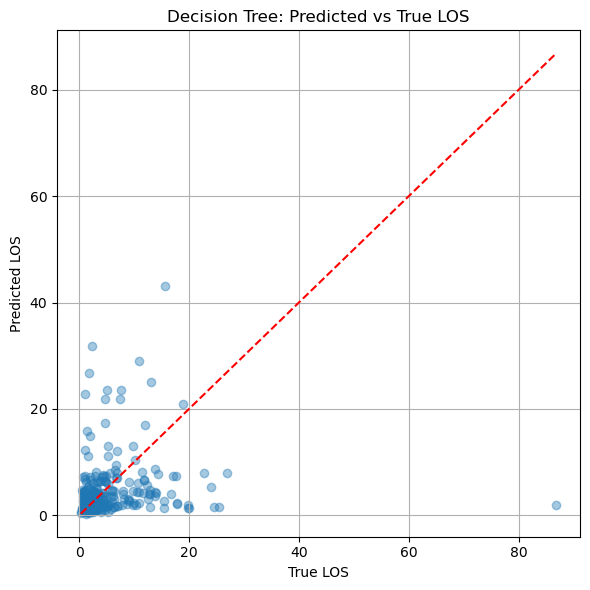

In [69]:
# === Scatter Plot ===
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_dt, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True LOS")
plt.ylabel("Predicted LOS")
plt.title("Decision Tree: Predicted vs True LOS")
plt.grid(True)
plt.tight_layout()
plt.savefig(ASSETS_PATH + "decision_tree_scatter.png")
plt.show()

#### Distribution of Prediction Errors for Decision Tree
This histogram represents the distribution of prediction errors made by the decision tree regressor on the test set, offering insight into the model’s generalization behavior and error dynamics.
Key observations include:
- Sharp central peak near zero: The majority of errors fall within a narrow range centered around 0, indicating that for many samples — especially those with short LOS — the decision tree produces relatively accurate predictions.
- Asymmetry and long tails: The distribution exhibits moderate right skewness, with a non-negligible number of positive errors (underestimations), and a smaller but still visible left tail (overestimations). However, a few extreme outliers are also present on both ends of the spectrum, most notably a very large positive error exceeding 80 days. These rare but severe mistakes drastically affect metrics like RMSE and reflect the model's inability to generalize across rare cases.
- Discrete jumps in error magnitude: The "stepped" appearance of the histogram is a hallmark of decision trees, which produce discrete predictions due to their piecewise constant structure. This further explains the blocky scatter plot observed earlier.
- Overfitting symptoms: The error distribution's shape — narrow but with extreme values — points to classic overfitting behavior: the model fits some parts of the data too well while failing dramatically on others.

This diagnostic reinforces the notion that, without pruning or hyperparameter control, decision trees can yield unstable and high-variance predictions — motivating the need for ensemble-based methods to mitigate these issues.

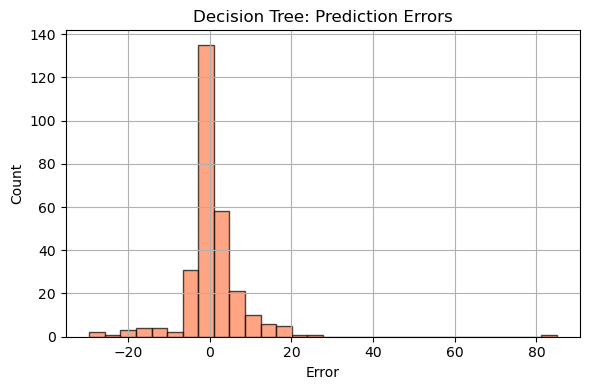

In [70]:
# === Histogram of Errors ===
errors_dt = y_test - y_pred_dt
plt.figure(figsize=(6, 4))
plt.hist(errors_dt, bins=30, alpha=0.7, color="coral", edgecolor="k")
plt.title("Decision Tree: Prediction Errors")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.savefig(ASSETS_PATH + "decision_tree_errors_histogram.png")
plt.show()

### Random Forest Regressor
This section introduces a Random Forest Regressor as a more robust, ensemble-based alternative to the previously tested linear and single-tree models. Random Forest is a bagging technique that builds an ensemble of decision trees, each trained on a bootstrap sample of the data and a random subset of features. By averaging the predictions of multiple de-correlated trees, the model significantly reduces variance and mitigates overfitting — key limitations observed in the standalone decision tree.
Here, we initialize a forest with 100 estimators using default hyperparameters. The number of estimators is generally sufficient for convergence and offers a good balance between accuracy and computational cost. The model is trained on the full training set, and predictions are immediately generated on the unseen test set.
Random Forests are well-suited to structured, tabular datasets like this one. They are capable of capturing complex, non-linear interactions without the need for explicit feature engineering or transformation, making them a reliable baseline for high-dimensional clinical prediction tasks such as ICU Length of Stay (LOS).

In [71]:
# === Model ===
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#### Evaluation Metrics for Random Forest
The evaluation of the Random Forest model reveals a noticeable improvement over both the linear and standalone decision tree regressors, particularly in terms of error stability and generalization:

MAE = 3.28: This is the lowest mean absolute error among the models evaluated so far, indicating improved accuracy in predicting the central tendency of LOS across the test set. The reduction compared to the linear model (MAE ≈ 3.76) and the decision tree (MAE ≈ 4.20) supports the effectiveness of ensembling in reducing overfitting and bias.

RMSE = 43.79: Although the RMSE is slightly higher than that of the linear model (42.95), it is dramatically lower than the decision tree (67.70). This suggests that the Random Forest is better at handling outliers and long-stay cases without overfitting to the training data.

R² = 0.10: The R² value, while still modest, shows improvement over the decision tree (which was negative) and is close to the linear baseline. This confirms that the Random Forest model is capturing some variance in the LOS, though the overall predictive power remains limited, likely due to intrinsic variability in the outcome and unmeasured clinical factors.

Taken together, these metrics reflect a balanced trade-off: the Random Forest offers higher robustness, lower variance, and overall greater reliability in LOS prediction than simpler models — making it a strong candidate for baseline deployment and further tuning or interpretation (e.g., via feature importance or SHAP analysis).

In [72]:
# === Evaluation ===
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"[Random Forest] MAE: {mae_rf:.2f}, RMSE: {rmse_rf:.2f}, R²: {r2_rf:.2f}")

[Random Forest] MAE: 3.28, RMSE: 43.79, R²: 0.10


#### Feature Importance Analysis for Random Forest
The plot illustrates the 15 most influential features identified by the Random Forest model in predicting ICU length of stay (LOS). Notably, some features that were expected to be informative (such as clinical biomarkers and input volumes) are indeed present, but the appearance of specific timestamps (e.g., INTIME_2125-09-06 11:03:01) at the top of the importance list suggests that certain datetime values were incorrectly retained as raw features instead of being transformed into meaningful variables (e.g., duration, weekday, or hour). This likely introduces data leakage or spurious signals into the model.

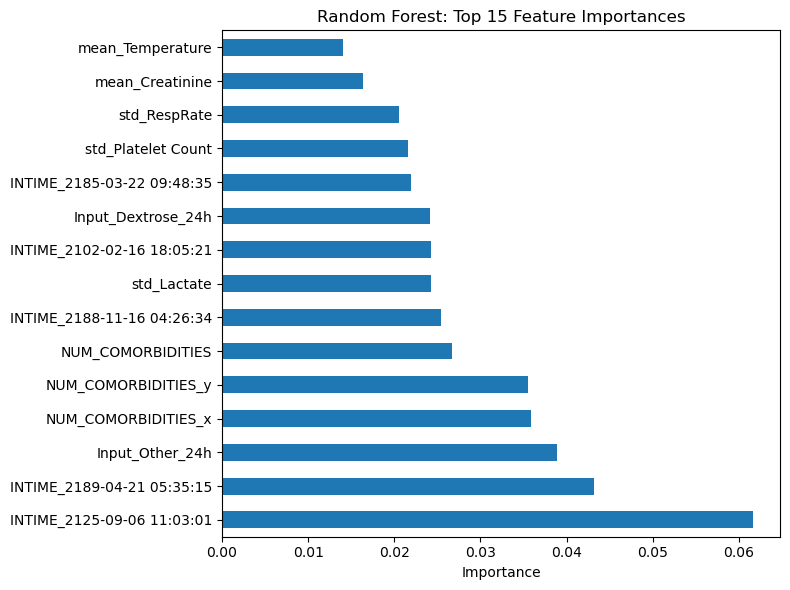

In [73]:
# === Feature Importance ===
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
importances.head(15).plot(kind="barh")
plt.title("Random Forest: Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(ASSETS_PATH + "random_forest_feature_importance.png")
plt.show()

### XGBoost Regressor
The XGBoost model was trained on the training set using default parameters, with parallel processing enabled via n_jobs=-1. After training, predictions on the test set were obtained using predict(). XGBoost is a gradient boosting framework known for its robustness, performance on tabular data, and its ability to handle missing values internally. However, without hyperparameter tuning, the model may still underfit or overfit, depending on the complexity of the data.

In [74]:
# === Model ===
xgb = XGBRegressor(random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

#### Evaluation Metrics for XGBoost
The performance of four regression models (Linear Regression, Decision Tree, Random Forest, XGBoost) was evaluated using MAE, RMSE, and R². Surprisingly, none of the models demonstrated strong predictive power, with R² values close to 0 or even negative. The Random Forest achieved the best MAE (3.28), indicating the smallest average error in predicting ICU length of stay, albeit with a modest R² of 0.10. The XGBoost model, despite its complexity, did not outperform the simpler models, possibly due to suboptimal hyperparameters or low signal-to-noise ratio in the features. The Decision Tree clearly overfit the training data, as shown by the worst R² score (–0.38).

In [75]:
# === Evaluation ===
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost] MAE: {mae_xgb:.2f}, RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.2f}")

[XGBoost] MAE: 3.55, RMSE: 48.43, R²: 0.01


#### Residual Error Distribution for XGBoost
The histogram shows the distribution of residuals (i.e., the difference between actual and predicted LOS) for the XGBoost model. Most residuals are centered around zero, suggesting that the model captures the overall trend reasonably well. However, the long right tail indicates a subset of outliers where the model significantly underestimates the length of stay (with residuals > 40). This positive skewness could stem from extreme cases with unusually long ICU stays or from a model that fails to generalize in high-variance contexts.

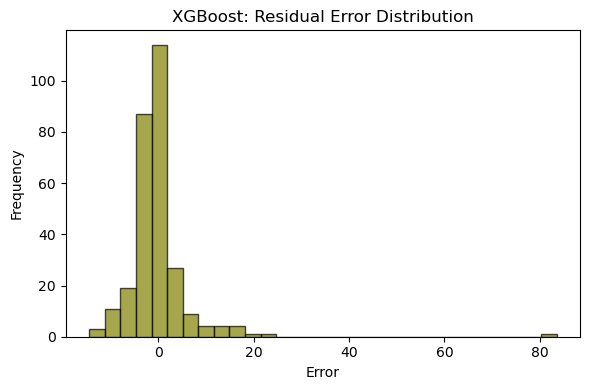

In [79]:
# === Residuals ===
residuals_xgb = y_test - y_pred_xgb
plt.figure(figsize=(6, 4))
plt.hist(residuals_xgb, bins=30, alpha=0.7, color="olive", edgecolor="k")
plt.title("XGBoost: Residual Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(ASSETS_PATH + "xgboost_residuals_histogram.png")
plt.show()

#### Top 15 Feature Importances for XGBoost
The plot ranks the 15 most important features used by the XGBoost regressor. At the top is FIRST_CAREUNIT_TSICU, indicating that patients initially admitted to the Trauma Surgical ICU have a significantly different LOS profile. Other important features include admission timestamps (e.g., INTIME_2125-09-06 11:03:01), again suggesting data leakage or leakage-like encoding of specific datetime values. Input volumes (Input_Other_24h), lactate variability (std_Lactate), and comorbidity counts (NUM_COMORBIDITIES_x) also emerge as relevant factors, aligning with known clinical expectations. Categorical encodings such as INSURANCE_Medicare and ADMISSION_LOCATION types seem to carry non-negligible influence.

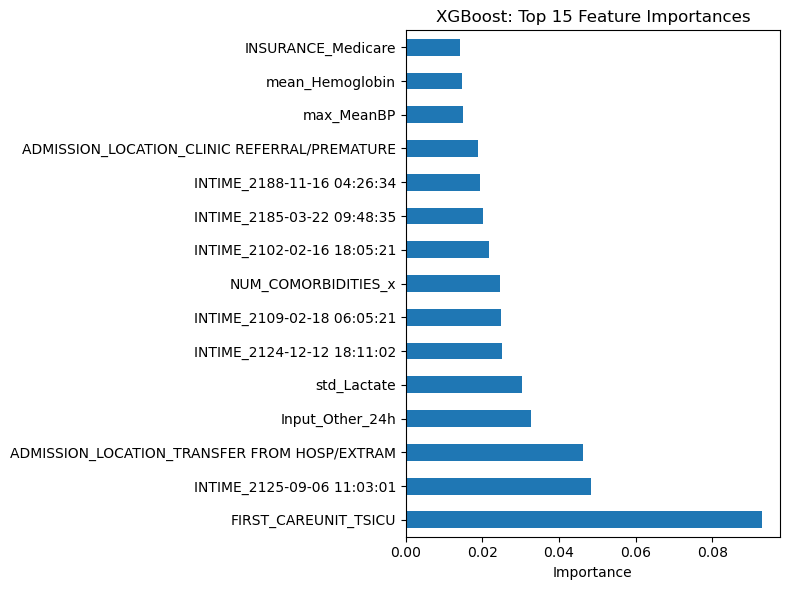

In [80]:
# === Feature Importance ===
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
xgb_importances.head(15).plot(kind="barh")
plt.title("XGBoost: Top 15 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.savefig(ASSETS_PATH + "xgboost_feature_importance.png")
plt.show()

### Hyperparameter Tuning (Grid/Randomized Search)
To improve the performance of the XGBoost regressor, a grid search was applied using 5-fold cross-validation and negative MAE as the scoring metric. The search explored a range of values for key hyperparameters: number of estimators, tree depth, learning rate, and subsampling ratio. After selecting the best configuration, the final model was retrained and evaluated on the test set. This procedure allows for a more stable and potentially less overfit model, as it systematically explores trade-offs between bias and variance.
After performing a grid search over 24 hyperparameter combinations and 5-fold cross-validation (120 total fits), the optimal configuration for the XGBoost regressor was found to be:
- learning_rate: 0.1
- max_depth: 5
- n_estimators: 100
- subsample: 1
  
The cross-validated negative MAE was –3.78. However, when applied to the test set, the model achieved a MAE of 3.56, RMSE of 45.90, and R² of 0.06 — showing only marginal improvement compared to the default model and still low overall explanatory power. These results suggest that the model remains limited in its ability to generalize LOS patterns, possibly due to limited feature richness or high noise.

In [78]:
param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1]
}

xgb_cv = XGBRegressor(random_state=42, n_jobs=-1)

grid_search = GridSearchCV(
    estimator=xgb_cv,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best MAE (neg):", grid_search.best_score_)

# Valutazione sul test set con il miglior modello
best_xgb = grid_search.best_estimator_
y_pred_best_xgb = best_xgb.predict(X_test)

mae_best = mean_absolute_error(y_test, y_pred_best_xgb)
rmse_best = mean_squared_error(y_test, y_pred_best_xgb)
r2_best = r2_score(y_test, y_pred_best_xgb)

print(f"[Tuned XGBoost] MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R²: {r2_best:.2f}")


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1}
Best MAE (neg): -3.7789919508614944
[Tuned XGBoost] MAE: 3.56, RMSE: 45.90, R²: 0.06


## PyTorch Neural Network Modeling
### Environment and Reproducibility

## Tensor Conversion and DataLoaders
### Conversion from Pandas to Torch
### Construction of TensorDataset and DataLoader

## Neural Network Model Design
### PyTorch Model Definition
### Architecture Selection
### Loss Function and Optimizer

## Training and Validation
### Training Loop
### Validation and Prediction
### Evaluation Metrics for Neural Network

## Model Interpretation
### SHAP Interpretation
### Feature Attribution Visualization

## Final Model Comparison and Discussion
### Summary Table of Model Metrics
### Visualization of Model Performance

## Model Saving and Export
### Saving Models
### Export of Predictions and Plots

## Discussion and Lessons Learned
### Strengths and Limitations
### Future Improvements